<a href="https://colab.research.google.com/github/shaheriar/CS-228-Deep-Learning-Project/blob/Experimental-Changes/CS228FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 228 Final Project
## Enhancing Image Captioning with Deep Learning Models
### Saul Gonzalez - sgonz081
### Shaheriar Malik - smali032

Dataset: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

Image captioning is a difficult task that is one step above image classification since we are
generating an actual text description of each image. So, deep learning would be an obvious choice in this case since generating text for a variable input image is a difficult task that would require a complex model.


In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchtext.data import get_tokenizer
from torchtext.data.metrics import bleu_score
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
from torchtext.data.metrics import bleu_score

from copy import deepcopy

from PIL import Image
import nltk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

import random
import os
import natsort
import cv2
from collections import Counter, OrderedDict

from textwrap import wrap
from IPython.display import clear_output

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -n "/content/drive/MyDrive/ImageCaptioningDataset/flickr30k_images.zip" -d "/content"
clear_output()

In [4]:
raw_df = pd.read_csv('/content/drive/MyDrive/ImageCaptioningDataset/results.csv', sep='|', header = None)
#raw_df.drop([' comment_number'],axis=1, inplace=True)
#raw_df.columns = raw_df.columns.str.replace(' ', '')
#raw_df.loc[19999,'comment'] = 'A dog runs across the grass .'
#raw_df.to_csv('out.csv',sep='|',index=False)
#raw_df.iloc[[19999]]

In [5]:
# read, resize and zero pad images. Returns image tensor [3, 256, 256]
def readImage(path):
    desired_size = 256 # 256 x 256
    image = cv2.imread(path)
    old_size = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    transform = transforms.ToTensor()
    tensor = transform(new_im)
    return tensor

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    num = temp_df.shape[0]
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
        image = readImage(f"/content/flickr30k_images/{temp_df.image_name[i]}")
        plt.imshow(image.permute(1, 2, 0))
        plt.title("\n".join(wrap(temp_df.comment[i], 30)))

#num = 5
#display_images(raw_df.sample(num))

In [6]:
# Build vocabulary for Captions
def build_vocab(captions,tokenizer,max_len):
  counter = Counter()
  current_max = max_len
  for caption in captions:
    sentence = caption.strip()
    tokens = tokenizer(sentence)
    if len(tokens) > current_max:
      current_max = len(tokens)
    counter.update(tokens)
  sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
  dictionary = OrderedDict(sorted_by_freq)
  dictionary = dict(dictionary)
  dictionary = OrderedDict(dictionary)
  return vocab(dictionary,specials=['<PAD>','<SOS>','<EOS>','<UNK>']), current_max

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, label_csv, transform=None):
        self.data_dir = data_dir
        self.target_len = -1

        self.data_df = pd.read_csv(label_csv, sep='|',header=None)
        self.data_df = self.data_df.dropna()
        #self.data_df.drop([' comment_number'],axis=1, inplace=True)
        #self.data_df.columns = self.data_df.columns.str.replace(' ', '')
        self.captions = self.data_df[1] # 0 is image_name, 1 is comment
        self.captions = self.captions.apply(lambda x: x.lower())
        self.captions = self.captions.apply(lambda x: x.replace("[^A-Za-z]",""))
        self.captions = self.captions.apply(lambda x: x.replace("\s+"," "))
        self.captions = self.captions.apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

        self.transform = transform
        self.image_paths = self.data_df[0]#os.listdir(data_dir)  # Assumes images are directly under data_dir

        self.tokenizer = get_tokenizer("basic_english")
        self.vocab, self.target_len = build_vocab(self.captions.tolist(),self.tokenizer,self.target_len)
        self.target_len += 2
        self.vocab.set_default_index(self.vocab['<UNK>'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = (image - np.mean(image))/np.std(image) # normalize
        image = Image.fromarray(image)# * 255).astype(np.uint8))
        # = Image.open(image_path).convert("RGB")
        caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)

        # Vectorize the given caption using our dataset's vocabulary
        caption = caption.strip()
        caption = self.tokenizer(caption)
        caption_vector = [self.vocab['<SOS>']]
        caption_vector.extend([self.vocab[word] for word in caption])
        caption_vector.append(self.vocab['<EOS>'])

        # Add padding to the vector if it needs it
        if len(caption_vector) < self.target_len:
          for i in range(self.target_len - len(caption_vector)):
            caption_vector.append(self.vocab['<PAD>'])

        # Return the processed image and any associated labels
        return image, torch.tensor(caption_vector)

In [8]:
weights = models.Wide_ResNet50_2_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

data_dir = '/content/flickr30k_images/'
label_csv = '/content/drive/MyDrive/ImageCaptioningDataset/results.csv'
dataset = CustomDataset(data_dir, label_csv, transform=preprocess)
len(dataset)

158915

In [9]:
test,train = random_split(dataset, [int(len(dataset)*0.3)+1, int(len(dataset)*0.7)])
print(len(test),len(train))

47675 111240


In [10]:
image_paths = raw_df[0]
image_paths[0]

'1000092795.jpg'

In [11]:
batch_size = 37
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [12]:
vocab_size = len(dataset.vocab)
vocab_size

20205

In [ ]:
# import time
# i = 0
# for img, file_name in dataloader:
#   clear_output()
#   #print(label[0])
#   #print(raw_df['image_name'])
#   plt.imshow(img[0].permute(1,2,0))
#   print(list(raw_df.loc[raw_df['image_name'] == file_name[0]].comment)[0])
#   i+=5
#   plt.show()
#   time.sleep(1)

## Encoder & Decoder

In [13]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [14]:
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [15]:
class Encoder(nn.Module):
  def __init__(self,embed_size):
    super(Encoder, self).__init__()
    # Load the pretrained ResNet-101 model
    self.resnet = models.wide_resnet50_2(weights=weights)
    self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)

  def forward(self,images):
    features = self.resnet(images)
    features = features.unsqueeze(1)
    return features

In [16]:
class Decoder(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=dataset.vocab['<PAD>'])
    self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
    self.attention = nn.Linear(embed_size,embed_size)
    self.fc = nn.Linear(hidden_size, vocab_size)

  def forward(self, features, captions):
    embeddings = self.embedding(captions)
    combined = torch.cat((features, embeddings), dim=1)
    

    attention_weights = torch.softmax(self.attention(combined), dim=1)
    attention_encoding = attention_weights * combined

    lstm_out, _ = self.lstm(attention_encoding)

    outputs = self.fc(lstm_out)
    return outputs

In [17]:
embed_size = 256
hidden_size = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

encoder = Encoder(embed_size).to(device)
for param in encoder.parameters():
    param.requires_grad = False

decoder = Decoder(embed_size, hidden_size, vocab_size).to(device)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 75.3MB/s]


In [ ]:
def training():
  criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
  optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
  num_epochs = 10

  
  for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    i = 0
    for images, captions in train_loader:
        images = images.to(device, dtype=torch.float)
        captions = captions.to(device)
        

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions[:,:-1])
        
        # Reshape captions for loss calculation
        targets = captions[:, :].reshape(-1)
        
        #print(targets.shape)

        # Compute loss
        #print(targets.size())
        loss = criterion(outputs.reshape(-1, vocab_size), targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss
        if i % 100 == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, len(train_loader), loss.item()))
        i+=1
    # Create a checkpoint for training
    checkpoint(decoder, f"/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder-epoch-{epoch}.pth")

training()

Epoch [1/10], Step [0/3007], Loss: 9.9152
Epoch [1/10], Step [100/3007], Loss: 5.6723
Epoch [1/10], Step [200/3007], Loss: 4.8947
Epoch [1/10], Step [300/3007], Loss: 5.0251
Epoch [1/10], Step [400/3007], Loss: 4.6408
Epoch [1/10], Step [500/3007], Loss: 4.7736
Epoch [1/10], Step [600/3007], Loss: 4.2647
Epoch [1/10], Step [700/3007], Loss: 4.2517
Epoch [1/10], Step [800/3007], Loss: 3.9486
Epoch [1/10], Step [900/3007], Loss: 3.6612
Epoch [1/10], Step [1000/3007], Loss: 3.5289
Epoch [1/10], Step [1100/3007], Loss: 3.5899
Epoch [1/10], Step [1200/3007], Loss: 3.2364
Epoch [1/10], Step [1300/3007], Loss: 3.5642
Epoch [1/10], Step [1400/3007], Loss: 3.4479
Epoch [1/10], Step [1500/3007], Loss: 2.9854
Epoch [1/10], Step [1600/3007], Loss: 3.1974
Epoch [1/10], Step [1700/3007], Loss: 3.3575
Epoch [1/10], Step [1800/3007], Loss: 3.2743
Epoch [1/10], Step [1900/3007], Loss: 3.3987
Epoch [1/10], Step [2000/3007], Loss: 3.2464
Epoch [1/10], Step [2100/3007], Loss: 3.0468
Epoch [1/10], Step [22

In [ ]:
torch.save(decoder.state_dict(), '/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder.pt')

In [ ]:
embed_size = 256
hidden_size = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

encoder = Encoder(embed_size)
decoder = Decoder(embed_size, hidden_size, vocab_size)
encoder.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/encoder3.pt'))
decoder.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/decoder3.pt'))
encoder.to(device)
decoder.to(device)

Decoder(
  (embedding): Embedding(20205, 256, padding_idx=0)
  (lstm): LSTM(256, 512, batch_first=True)
  (attention): Linear(in_features=256, out_features=256, bias=True)
  (fc): Linear(in_features=512, out_features=20205, bias=True)
)

In [ ]:
def inference_function(image):
  encoder.eval()
  decoder.eval()

  features = encoder(image)

  caption = [dataset.vocab['<SOS>']]
  with torch.no_grad():
    while len(caption) < dataset.target_len and caption[-1] != dataset.vocab['<EOS>']:
      # features = features.to(device, dtype=torch.float)
      captions = torch.tensor(caption).unsqueeze(0).to(device)
      #print(captions[0])
      outputs = decoder(features, captions)
      #print(outputs.argmax(2))
      _, pred_words = torch.max(outputs,2)
      pred_words = pred_words.cpu().numpy()
      caption.append(pred_words[-1][-1])
  i = 0
  full_caption = []
  for idx in caption:
    if dataset.vocab.lookup_token(idx) not in ['<PAD','<SOS>','<EOS>']:
      #print(dataset.vocab.lookup_token(idx))
      full_caption.append(dataset.vocab.lookup_token(idx))
      i += 1
  #full_caption = [dataset.vocab.lookup_token(idx) for idx in caption if dataset.vocab.lookup_token(idx) not in ['<PAD','<SOS>','<EOS>']]
  return full_caption

In [ ]:
k = 1000
normal_image = dataset[k][0]
image = dataset[k][0].unsqueeze(0)
image = image.to(device, dtype=torch.float)
full_caption = inference_function(image)

In [ ]:
full_caption

['two', 'dogs', 'are', 'running', 'on', 'the', 'beach']

'two dogs are running on the beach'

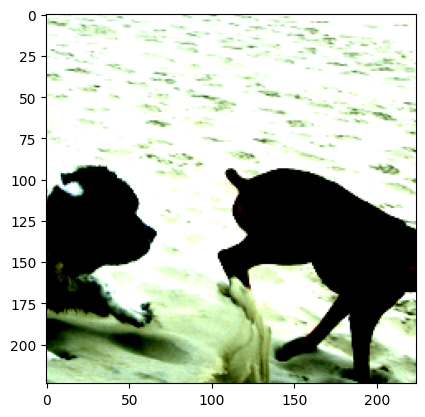

In [ ]:
plt.figure()
plt.imshow(normal_image.permute(1, 2, 0))
' '.join(full_caption)

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        
        # Load the pretrained ResNet-101 model
        self.resnet = models.wide_resnet50_2(weights=None)
        self.resnet.fc = nn.Linear(2048, embed_size)
        self.dropout = nn.Dropout(p=0.5)

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=dataset.vocab['<PAD>'])
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.attention = nn.Linear(embed_size,embed_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):

        features = self.resnet(images)
        features = features.unsqueeze(1)
        features = self.dropout(features)

        embeddings = self.embedding(captions)

        combined = torch.cat((features, embeddings), dim=1)

        attention_weights = torch.softmax(self.attention(combined), dim=1)
        attention_encoding = torch.sum(combined * attention_weights, dim=1)

        lstm_out, _ = self.lstm(combined)

        outputs = self.fc(lstm_out)


        return outputs

In [ ]:
embed_size = 256  # Size of the word embedding
hidden_size = 512  # Size of the LSTM hidden state

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size).to(device)

In [ ]:
def mixup(x, y, a):
    lam = np.random.beta(a,a)
    rand = torch.randperm(batch_size)
    x2 = x[rand,:]
    y2 = y[rand,:]
    X = lam * x + (1 - lam) * x2
    Y = lam * y + (1 - lam) * y2
    #print(Y)
    return X, Y

def cutout(image, k):
    x = np.random.randint(0, 128-k)
    y = np.random.randint(0, 128-k)
    image[:, x:x+k, y:y+k] = 0
    return image

def standard_augmentation(image,k):
    k1 = np.random.randint(-k, k)
    k2 = np.random.randint(-k, k)
    image = np.roll(image, k1, axis=1)
    image = np.roll(image, k2, axis=2)
    if (k1 > 0):    
        image[:, :k1, :] = 0
    else:
        image[:, k1:, :] = 0
    if (k2 > 0):
        image[:, :, :k2] = 0
    else:
        image[:, :, k2:] = 0
    if (np.random.rand() < 0.5):
        image = np.flip(image, axis=2)
    return image

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

def training():
  for epoch in range(num_epochs):
      i = 0
      copy_train_loader = deepcopy(train_loader)
      for images, captions in copy_train_loader:
          for j in range(len(images)):
            if (np.random.rand() < 0.5):
              images[j] = cutout(images[j], 64)
            images[j] = torch.from_numpy(standard_augmentation(images[j],16).copy())
          #images, captions = mixup(images, captions, 0.4)
          images = images.to(device, dtype=torch.float)
          captions = captions.to(device)

          # Forward pass
          # captions[:, :-1]
          outputs = model(images, captions[:, :-1])

          # Reshape captions for loss calculation
          targets = captions[:, :].reshape(-1)
          
          # Compute loss
          loss = criterion(outputs.reshape(-1, vocab_size), targets)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Print the loss
          if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, len(train_loader), loss.item()))
          i+=1

#model.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/model_path.pt'), strict=False)
#training()

In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/model_path.pt'), strict=False)

In [ ]:
normal_image = dataset[0][0]
image = dataset[0][0].unsqueeze(0)
caption = dataset[0][1].unsqueeze(0)
image = image.to(device, dtype=torch.float)
caption = caption.to(device)

In [ ]:
model.eval()
with torch.no_grad():
  outputs = model(image,caption)
  _,preds = torch.max(outputs,2)

In [ ]:
translated_preds = []
for _,num in enumerate(preds[0]):
  idx = num.item()
  if idx not in dataset.vocab.lookup_indices(['<PAD>','<SOS>','<EOS>']):
    translated_preds.append(dataset.vocab.lookup_token(idx))

pred_caption = ' '.join(translated_preds)
print(pred_caption)

dominance 3d combatants apprentice reacts stewart pastels mesh-like tips undressed nerdy two-way pie-filling hoyt dumps rides sends stange flying sports speedway speedway foot- wiht wiht smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley smiley


In [ ]:
translated_caption = []
for _,num in enumerate(caption[0]):
  idx = num.item()
  if idx not in dataset.vocab.lookup_indices(['<PAD>','<SOS>','<EOS>']):
    translated_caption.append(dataset.vocab.lookup_token(idx))

In [ ]:
bleu_score(translated_preds[:17],translated_caption)

AssertionError: ignored

In [ ]:
plt.figure()
plt.imshow(normal_image.permute(1, 2, 0))
print(pred_caption)

In [ ]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/ImageCaptioningDataset/model_UPDATED_2.pt')